# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import time
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import matplotlib.pyplot as plt
import sys
from torchvision.transforms import functional as TF
import torchvision.transforms as transforms
import random
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import scipy.io as sio


# Re-Parametrizable block here

In [2]:
class RepBlock(nn.Module):
  def __init__(self, channel_in, channel_out, is_rep_block=False):
    super(RepBlock, self).__init__()
    self.is_rep_block = is_rep_block
    self.conv3x3 = nn.Conv2d(channel_in, channel_out, kernel_size=3, padding=1)

    self.conv1x1 = nn.Conv2d(channel_in, channel_out, kernel_size=1)

  def forward(self, x):
    identity = x
    out = F.relu(self.conv3x3(x))
    if self.is_rep_block:
      out = out + identity  # Residual connection
      out = self.conv1x1(out)  # Optional 1x1 conv
    return out

# Barebones model with different training and inference layers here

In [3]:
class SCSRN(nn.Module):
  def __init__(self, base_channels = 32, upscale_factor = 2):
    super(SCSRN, self).__init__()

    self.upscale_factor = upscale_factor
    self.base_channels = base_channels

    # Initial convolution layer for both training and inference
    self.initial_conv = nn.Conv2d(3, self.base_channels, kernel_size=3, padding=1)

    # RepBlocks with 3x3 convolutions, used in both training and inference
    self.rep_blocks = nn.ModuleList([RepBlock(self.base_channels, self.base_channels) for _ in range(4)])

    # Additional 1x1 convolution for training
    self.conv1x1_train = nn.Conv2d(self.base_channels, self.base_channels, kernel_size=1)


    # Final convolution layer before final Rep-block
    self.final_conv_1 = nn.Conv2d(self.base_channels + 3, self.base_channels, kernel_size=3, padding=1)

    # Final Rep-block
    self.final_rep_block = RepBlock(self.base_channels, self.base_channels)

    self.last_conv = nn.Conv2d(self.base_channels, self.base_channels * (upscale_factor**2), kernel_size=3, padding=1)

    # The depth-to-space layer is implemented in PyTorch as pixel shuffle
    self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    self.end_conv = nn.Conv2d(self.base_channels, 3, kernel_size=3, padding=1)
    # self.final_conv_2 = nn.Conv2d(self.base_channels // 4, 3, kernel_size=3, padding=1)

  def forward(self, x, training=True):
    inp = x
    x = F.relu(self.initial_conv(x))

    # Pass through RepBlocks
    for rep_block in self.rep_blocks:
      if training:
        rep_block.is_rep_block = True
      x = rep_block(x)
    
    # Concatenate with input
    x = torch.cat((x, inp), dim=1)
    x = self.final_conv_1(x)
    if training:
      self.final_rep_block.is_rep_block = True
    x = self.final_rep_block(x)
    x = self.last_conv(x)
    x = self.pixel_shuffle(x)  # Upsample by factor of 2
    x = self.end_conv(x)
    x = torch.clamp(x, 0, 1)
    return x

In [4]:
class LCVG(nn.Module):
  def __init__(self, base_channels = 28, upscale_factor = 2):
    super(LCVG, self).__init__()

    self.base_channels = base_channels
    self.upscale_factor = upscale_factor

    self.conv1 = nn.Conv2d(3, self.base_channels, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(self.base_channels, self.base_channels, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(self.base_channels, self.base_channels, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(self.base_channels, self.base_channels, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(self.base_channels, self.base_channels, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(self.base_channels, 3 * (self.upscale_factor ** 2), kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(self.upscale_factor)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = self.conv6(x)
    x = torch.clamp(x, 0, 1)
    x = self.pixel_shuffle(x)
    return x


# Initialize models, quantization and loss criterion

In [5]:
import torch
import torch.nn as nn
from torchvision.models import vgg16

class PerceptualLoss(nn.Module):
    def __init__(self, device='cpu'):
        super(PerceptualLoss, self).__init__()
        self.device = device
        vgg_pretrained_features = vgg16(pretrained=True).features.to(device)
        self.slice1 = torch.nn.Sequential().to(device)
        self.slice2 = torch.nn.Sequential().to(device)
        self.slice3 = torch.nn.Sequential().to(device)
        self.slice4 = torch.nn.Sequential().to(device)
        
        for x in range(4):  # Conv1_1 to Conv1_2
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):  # Conv2_1 to Conv2_2
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):  # Conv3_1 to Conv3_3
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):  # Conv4_1 to Conv4_3
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        
        for param in self.parameters():
            param.requires_grad = False

        self.mse_loss = nn.MSELoss().to(device)

    def forward(self, predicted, target):
        # Normalize the input because VGG is trained on ImageNet
        predicted = (predicted + 1) / 2
        target = (target + 1) / 2

        predicted = predicted.to(self.device)
        target = target.to(self.device)

        predicted_features = self.slice4(self.slice3(self.slice2(self.slice1(predicted))))
        target_features = self.slice4(self.slice3(self.slice2(self.slice1(target))))
        
        perceptual_loss = self.mse_loss(predicted_features, target_features)
        pixel_loss = self.mse_loss(predicted, target)
        # pixel_loss = 0
        
        # Combine the losses
        return perceptual_loss + 2 * pixel_loss


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model
# model = SCSRN(base_channels=32, upscale_factor=2).to(device)
model = LCVG(base_channels=32, upscale_factor=2).to(device)

# Quantization config
# model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

# Fuse model if needed. e.g., model.fuse_model()

# Prepare model for QAT
# torch.quantization.prepare_qat(model, inplace=True)

# load weights if available
# model.load_state_dict(torch.load('super_resolution_model_stage_1.pth'))

# Loss function - Mean Squared Error (MSE) is commonly used for regression tasks like super-resolution
# criterion = nn.MSELoss()
# criterion = nn.L1Loss()
criterion = PerceptualLoss(device=device)

# Optimizer - Adam is a good default choice
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
# Define the scheduler
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=num_epochs, T_mult=1, eta_min=1e-5, last_epoch=-1, verbose=False)

# Total trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total Trainable parameters =", total_params)

c:\Users\heman\miniconda3\envs\766-torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\heman\miniconda3\envs\766-torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total Trainable parameters = 41356


# Handle data imports and Dataloader stuff here

In [7]:
# class SuperResolutionDataset(Dataset):
#     def __init__(self, hr_root, lr_root, upscale_factor=4, patch_size=128, transform=None):
#         self.hr_root = hr_root
#         self.lr_root = lr_root
#         self.transform = transform
#         self.patch_size = patch_size
#         self.upscale_factor = upscale_factor
#         self.images = [f for f in os.listdir(hr_root) if os.path.isfile(os.path.join(hr_root, f))]

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         hr_image_name = self.images[idx]
#         lr_image_name = hr_image_name.replace('.png', 'x2.png')
        
#         hr_path = os.path.join(self.hr_root, hr_image_name)
#         lr_path = os.path.join(self.lr_root, lr_image_name)
        
#         hr_image = Image.open(hr_path).convert('RGB')
#         lr_image = Image.open(lr_path).convert('RGB')

#         hr_image = np.array(hr_image).astype(np.float32)
#         lr_image = np.array(lr_image).astype(np.float32)

#         hr_image = (hr_image - np.amin(hr_image)) / (np.amax(hr_image) - np.amin(hr_image))
#         lr_image = (lr_image - np.amin(lr_image)) / (np.amax(lr_image) - np.amin(lr_image))

#         hr_image = torch.from_numpy(hr_image)
#         lr_image = torch.from_numpy(lr_image)

#         # hr_image = Image.fromarray(hr_image)
#         # lr_image = Image.fromarray(lr_image)

#         # Calculate corresponding LR patch size
#         lr_patch_size = self.patch_size // self.upscale_factor

#         # Random crop coordinates for LR image
#         # lr_x1 = random.randint(0, lr_image.width - lr_patch_size)
#         # lr_y1 = random.randint(0, lr_image.height - lr_patch_size)

#         # # Corresponding HR crop coordinates
#         # hr_x1 = lr_x1 * self.upscale_factor
#         # hr_y1 = lr_y1 * self.upscale_factor
#         # hr_x2 = hr_x1 + self.patch_size
#         # hr_y2 = hr_y1 + self.patch_size

#         # # Extract patches
#         # lr_patch = TF.crop(lr_image, lr_y1, lr_x1, lr_patch_size, lr_patch_size)
#         # hr_patch = TF.crop(hr_image, hr_y1, hr_x1, self.patch_size, self.patch_size) 

#         # hr_patch = np.array(hr_patch).astype(np.float32)
#         # lr_patch = np.array(lr_patch).astype(np.float32)

#         # hr_patch = (hr_patch - np.amin(hr_patch)) / (np.amax(hr_patch) - np.amin(hr_patch))
#         # lr_patch = (lr_patch - np.amin(lr_patch)) / (np.amax(lr_patch) - np.amin(lr_patch))

#         while True:
#             lr_patch_size = self.patch_size // self.upscale_factor
#             lr_x1 = random.randint(0, lr_image.shape[1] - lr_patch_size)
#             lr_y1 = random.randint(0, lr_image.shape[0] - lr_patch_size)
#             hr_x1 = lr_x1 * self.upscale_factor
#             hr_y1 = lr_y1 * self.upscale_factor
#             hr_x2 = hr_x1 + self.patch_size
#             hr_y2 = hr_y1 + self.patch_size
#             lr_patch = TF.crop(lr_image, lr_y1, lr_x1, lr_patch_size, lr_patch_size)
#             hr_patch = TF.crop(hr_image, hr_y1, hr_x1, self.patch_size, self.patch_size)

#             if ((torch.max(hr_patch) - torch.min(hr_patch)) != 0) or ((torch.max(lr_patch) - torch.min(lr_patch)) != 0):
#                 break


#         if self.transform:
#             lr_patch = self.transform(lr_patch)
#             hr_patch = self.transform(hr_patch)

#         return lr_patch, hr_patch

# transform = Compose([
#     # Resize(desired_size),  # Resize the image to the desired size
#     ToTensor()
# ])
# dataset = SuperResolutionDataset(hr_root='./DIV2K_train_HR/', lr_root='DIV2K_train_LR_unknown/X2/', transform=transform, patch_size=128, upscale_factor=2)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True, pin_memory=True)

In [8]:
class PatchDataset(Dataset):
    def __init__(self, mat_dir):
        """
        Args:
            mat_dir (string): Directory with all the .mat files containing LR and HR patches.
        """
        self.mat_dir = mat_dir
        self.mat_files = [f for f in os.listdir(mat_dir) if f.endswith('.mat')]

    def __len__(self):
        return len(self.mat_files)

    def __getitem__(self, idx):
        mat_path = os.path.join(self.mat_dir, self.mat_files[idx])
        data = sio.loadmat(mat_path)
        lr_patch = torch.tensor(data['lr_patchx2'], dtype=torch.float32)
        hr_patch = torch.tensor(data['hr_patch'], dtype=torch.float32)
        
        # If your model expects a specific input shape or channel ordering, adjust the patches here
        
        return lr_patch, hr_patch

torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 256, 256])


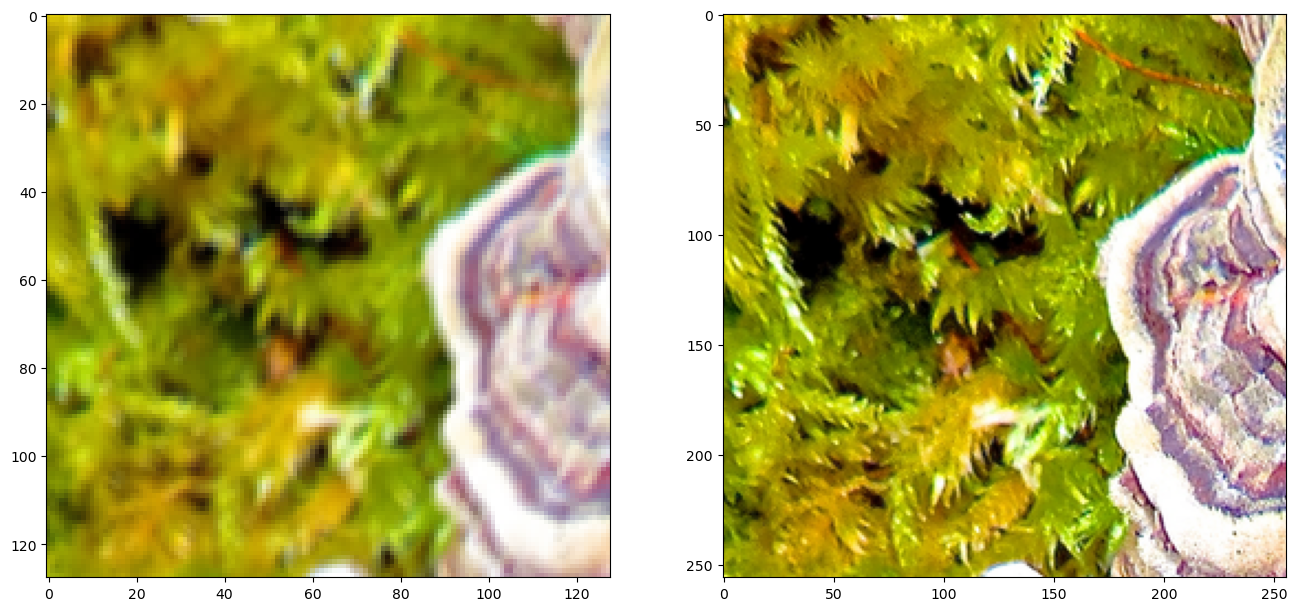

In [9]:
# Example usage
mat_dir = './Train_Patches/'  # The directory where you saved the .mat files
patch_dataset = PatchDataset(mat_dir)
dataloader = DataLoader(patch_dataset, batch_size=32, shuffle=True)

for lr_images, hr_images in dataloader:
  print(lr_images.shape)
  print(hr_images.shape)
  plt.figure(figsize=(16, 8))
  plt.subplot(121)
  plt.imshow(lr_images[0].permute(1,2,0))
  plt.subplot(122)
  plt.imshow(hr_images[0].permute(1,2,0))
  break

# Training the model

In [10]:
# Training loop
for epoch in range(num_epochs):
    # Generate a batch of random LR and HR image pairs
  total_loss = 0
  num_samples = 0
  start_time = time.time()
  running_time = 0
  total_samples = len(dataloader)
  for lr_images, hr_images in dataloader:
  # lr_images, hr_images = generate_data(batch_size, width, height, upscale_factor)
    

    lr_images = lr_images.to(device)
    hr_images = hr_images.to(device)

    optimizer.zero_grad()
    # sr_images = model(lr_images, training=True)
    sr_images = model(lr_images)
    loss = criterion(sr_images, hr_images)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    num_samples += 1

    running_avg_loss = total_loss / num_samples
    running_time = (time.time() - start_time)
    # if epoch > num_epochs // 2:
    #   # Update quantization scale and zero point
    #   model.apply(torch.quantization.disable_observer)
    
    # if epoch > num_epochs - 1:
    #   # Freeze quantization scale and zero point
    #   model.apply(torch.nn.intrinits.modules.qat.freeze_bn_stats)

  # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_avg_loss:.4f}, Samples: {num_samples}/{total_samples}, Running Time: {running_time:.2f}s', end="\r")
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_avg_loss:.4f}, Samples: {num_samples}/{total_samples}, Running Time: {running_time:.2f}s', end="\n")


# Save the model

In [ ]:
torch.save(model.state_dict(), 'super_resolution_model_stage_1.pth')

# Test the time for inference here. Set training=False

In [ ]:

model.eval()

# model = torch.quantization.convert(model.eval().to('cpu'), inplace=False)

test_img = Image.open('./DIV2K_valid_LR_bicubic/X2/0853x2.png').convert('RGB')
gt_img = Image.open('./DIV2K_valid_HR/0853.png').convert('RGB')
test_img = TF.to_tensor(test_img)

data = test_img.unsqueeze(0).to(device)
# data = torch.randn(1, 3, width, height).to(device)
times = []
for i in range(500):
  torch.cuda.synchronize()
  start = time.time()
  with torch.no_grad():
    pred = model(data)

  torch.cuda.synchronize()
  end = time.time() - start
  times.append(end)

avg_time = np.mean(times)

print("Average Time per frame =", 1000*avg_time, "ms")
print("Average FPS =", 1/avg_time, "FPS")


Average Time per frame = 23.000627040863037 ms
Average FPS = 43.47707556943533 FPS


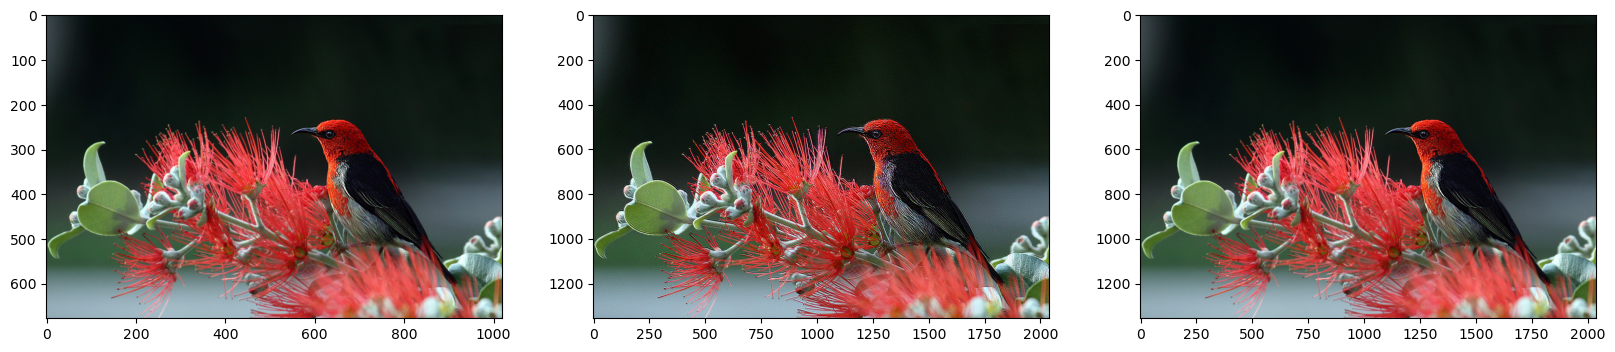

((678, 1020, 3), (1356, 2040, 3), (1356, 2040, 3))

In [ ]:
test_img = test_img.permute(1,2,0).cpu().detach().numpy()
pred_out = pred[0].permute(1, 2, 0).cpu().detach().numpy()
gt_img = np.asarray(gt_img)

# test_img = (test_img - test_img.min()) / (test_img.max() - test_img.min())
pred_out = (pred_out - pred_out.min()) / (pred_out.max() - pred_out.min())
# gt_img = (gt_img - gt_img.min()) / (gt_img.max() - gt_img.min())
gt_img = gt_img / 255

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(test_img)
plt.imsave('input_image.png',test_img)
plt.subplot(132)
plt.imshow(pred_out)
plt.imsave('output_image.png',pred_out)
plt.subplot(133)
plt.imshow(gt_img)
plt.imsave('gt_image.png',gt_img)
plt.show()

test_img.shape, pred_out.shape, gt_img.shape

In [ ]:
# Calculate PSNR
from skimage.metrics import peak_signal_noise_ratio
gt = np.asarray(gt_img)
gt = (gt - gt.min()) / (gt.max() - gt.min())
pred_out = pred[0].permute(1, 2, 0).cpu().detach().numpy()
psnr = peak_signal_noise_ratio(gt, pred_out)
print("PSNR =", psnr)

C:\Users\heman\AppData\Local\Temp\ipykernel_13432\1921316143.py:6: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(gt, pred_out)


PSNR = 20.01969310966498


In [ ]:
import cv2

inp = cv2.resize(test_img, (gt.shape[1], gt.shape[0]))
psnr = peak_signal_noise_ratio(gt, inp)
print("PSNR =", psnr)

PSNR = 35.47182816996578


C:\Users\heman\AppData\Local\Temp\ipykernel_13432\2232474644.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(gt, inp)


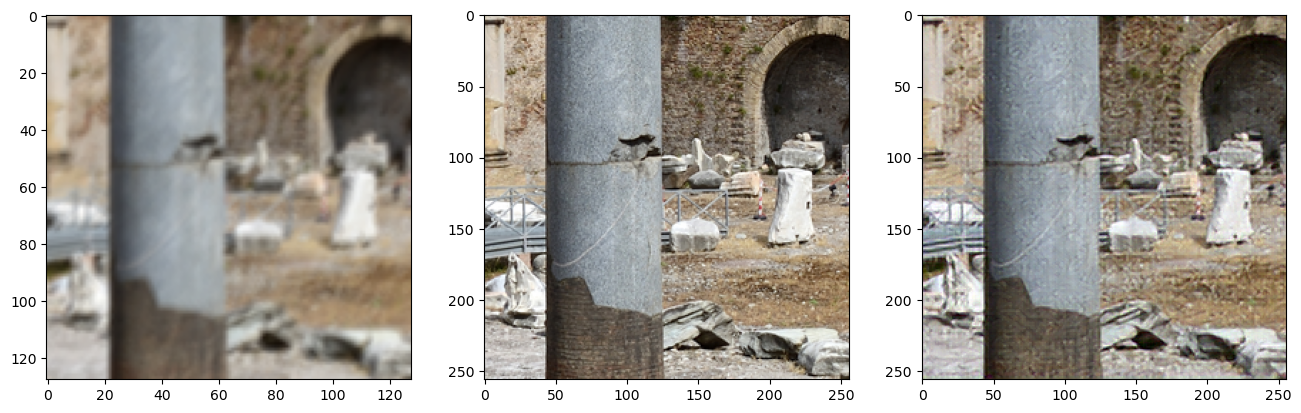

In [ ]:
for i, j in dataloader:
  inp = i[0]
  gt = j[0]
  pred = model(inp.unsqueeze(0).to(device), training=False)
  break

# Plot images
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(inp.permute(1,2,0))
plt.subplot(132)
plt.imshow(gt.permute(1,2,0))
plt.subplot(133)
plt.imshow(pred[0].permute(1,2,0).cpu().detach().numpy())
plt.show()

In [ ]:
inp = test_img
gt = gt_img

# change the images as channels first
inp = inp.transpose(2,0,1)
gt = gt.transpose(2,0,1)

sio.savemat('test.mat', {'inp': inp, 'gt': gt})

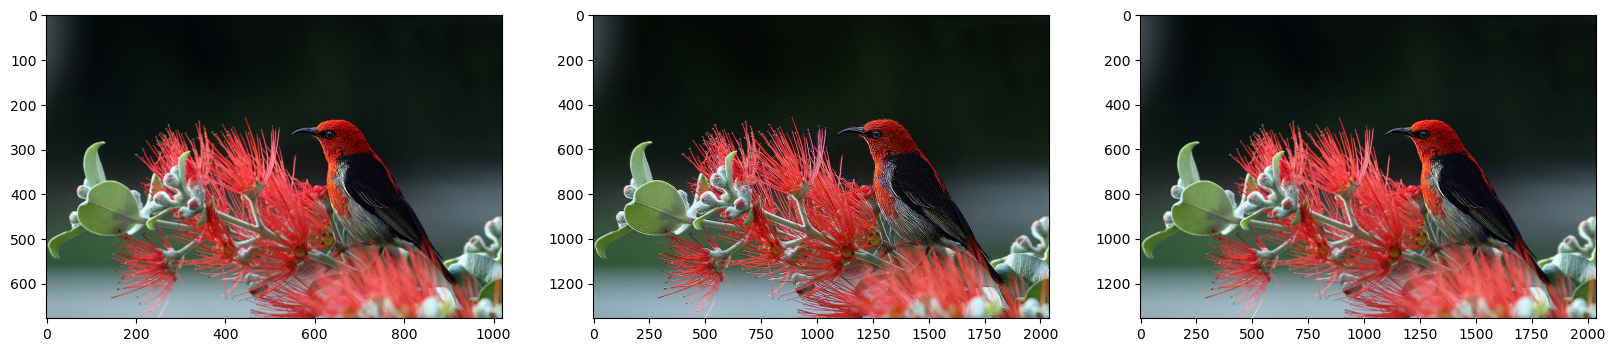

In [ ]:
test = sio.loadmat("test.mat")
inp = test['inp']
gt = test['gt']

inp = torch.tensor(test['inp'], dtype=torch.float32).unsqueeze(0)
gt = torch.tensor(test['gt'], dtype=torch.float32).unsqueeze(0)

pred = model(inp.to(device), training=False)
# pred = (pred - pred.min()) / (pred.max() - pred.min())

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(inp[0].permute(1,2,0))
plt.imsave('input_image.png',test_img)
plt.subplot(132)
plt.imshow(pred[0].permute(1, 2, 0).cpu().detach().numpy())
plt.imsave('output_image.png',pred_out)
plt.subplot(133)
plt.imshow(gt[0].permute(1, 2, 0).cpu().detach().numpy())
plt.imsave('gt_image.png',gt_img)
plt.show()

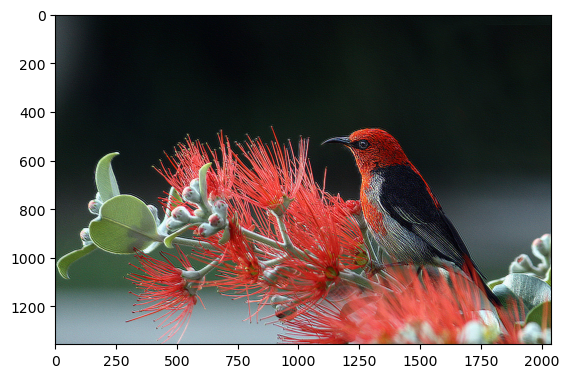

In [ ]:
# pred = (pred - pred.min()) / (pred.max() - pred.min())
pred = torch.clamp(pred, 0, 1)
plt.imshow(pred[0].permute(1, 2, 0).cpu().detach().numpy())